In [1]:
# default_exp analyses

In [2]:
#| code-summary: -- load dependencies and data and select parameters
#| output: asis

analysis_overview = """
# The Serial Position Effect
The serial position effect describes how our memory is affected by the position of information in a sequence or list. Research tends to find that people best remember the first and last items in a series and find it hard to remember the middle items. To measure the serial position effect, research participants perform a free recall task where they study a list of items and subsequently "freely" recall the items in the order in which they come to mind. The recall rate of each item at each study position across these lists reflects the serial position effect.
"""

analysis_tag = 'spc'
data_paths = ["../../data/CDCATBEH.csv", "../../data/LohnasKahana2014.csv", "../../data/HowardKahana2005.csv"]
trial_queries = [
    ["list_type == 'light'", "list_type == 'heavy'"], 
    ["condition == 1", "condition == 2", "condition == 3", "condition == 4"], 
    ["condition == 0", "condition == 1", "condition == 2"]
    ]
query_labels = trial_queries

show_figure = True
regenerate_figure = True
section_tags = ["CDCATBEH", "LohnasKahana2014", "HowardKahana2005"]
figures_path = "figures/"
figure_caption = """The serial position effect measured as a function of list length using data from @{}."""

print(analysis_overview)


# The Serial Position Effect
The serial position effect describes how our memory is affected by the position of information in a sequence or list. Research tends to find that people best remember the first and last items in a series and find it hard to remember the middle items. To measure the serial position effect, research participants perform a free recall task where they study a list of items and subsequently "freely" recall the items in the order in which they come to mind. The recall rate of each item at each study position across these lists reflects the serial position effect.



In [3]:
# export
#| code-summary: -- specify serial position effect analysis code

from compmemlearn.datasets import events_metadata, generate_trial_mask
import matplotlib.pyplot as plt
from numba import njit
import seaborn as sns
import pandas as pd
import numpy as np

@njit(nogil=True)
def recall_by_all_study_positions(recall_by_first_study_position, presentations, max_repeats=3):
    
    trials_shape = np.shape(recall_by_first_study_position)
    result = np.zeros(
            (max_repeats, trials_shape[0], trials_shape[1]), dtype=np.int32)

    for trial_index in range(len(recall_by_first_study_position)):

        trial = recall_by_first_study_position[trial_index]
        presentation = presentations[trial_index]
        
        for recall_index in range(len(trial)):

            if trial[recall_index] == 0:
                continue

            presentation_positions = np.nonzero(
                presentation[trial[recall_index] - 1] == presentation)[0] + 1

            result[:len(presentation_positions), trial_index, recall_index] = presentation_positions

    return result

@njit(nogil=True)
def fast_spc(trials, item_count):
    return np.bincount(trials.flatten(), minlength=item_count+1)[1:]/len(trials)

@njit(nogil=True)
def flex_mixed_spc(trials, presentations):
    "Variant of fast_spc that works with lists that contain an arbitrary number of item repetitions."

    list_length = len(presentations[0])
    result = np.zeros(list_length, dtype=np.int32)
    all_study_positions = recall_by_all_study_positions(trials, presentations) 
    
    for trial_index in range(len(trials)):
        for study_position in range(list_length):
            result[study_position] += study_position+1 in all_study_positions[:,trial_index]
    
    return result/len(trials)

def plot_spc(data, trial_query, contrast_name=None, labels=None, axis=None):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)[:3]
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        presentations = presentations[chose]
        trial_mask = trial_mask[chose]

        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            if (presentations == np.arange(list_length)).all():
                spc = fast_spc(trials[subject_specific_trial_mask], list_length)
            else:
                spc = flex_mixed_spc(
                    trials[subject_specific_trial_mask], presentations[subject_specific_trial_mask])
            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "input": np.arange(1, list_length + 1),
                    "recall": spc,
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result).reset_index()

    sns.lineplot(
        ax=axis, data=result, x='input', y='recall', err_style='bars', hue=contrast_name)
    axis.set(xlabel='Study Position', ylabel='Recall Rate')
    axis.set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
    axis.set_ylim((0, 1))

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis, result

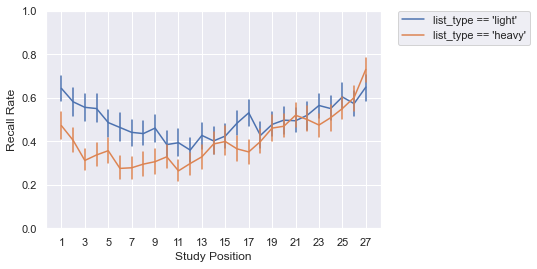

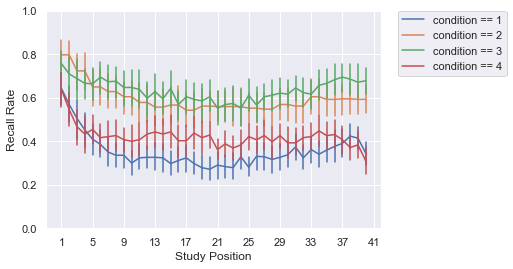

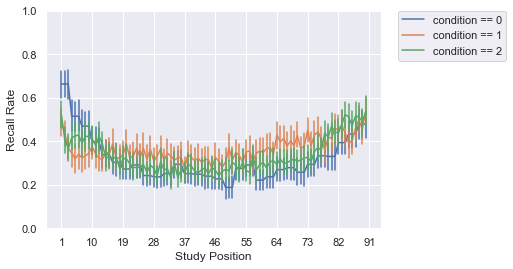

In [4]:
#| code-summary: -- perform and visualize spc using pre-defined parameters
#| output: asis

import os.path

sns.set(style='darkgrid')

for i in range(len(data_paths)):
    section_tag = section_tags[i]
    trial_query = trial_queries[i]
    query_label = query_labels[i]
    data_path = data_paths[i]

    if regenerate_figure or show_figure:
        ax = None
        for query in trial_query:

            events = pd.read_csv(data_path)
            trials, list_lengths, presentations = events_metadata(events)[:3]
            ax = plot_spc([events], query, labels=[query], axis=ax)[0]

        ax.legend(query_label, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        if regenerate_figure:
            plt.savefig(
                figures_path+f'{section_tag}_{analysis_tag}.pdf', bbox_inches="tight")
                
        if show_figure:
            plt.show()
        else:
            print(
                f"""::: {{#fig-{section_tag}_{analysis_tag} layout-valign="center"}}
                
![]({figures_path}{section_tag}_{analysis_tag}.pdf)

{figure_caption}
:::""");
        plt.close()

    else:
        if not os.path.isfile(f'{figures_path}{section_tag}_{analysis_tag}.pdf'):
            print(
                f'Figure not found at {figures_path}{section_tag}_{analysis_tag}.pdf. Run with regenerate_figure=True to generate.')
        else:
            print(
                f"""::: {{#fig-{section_tag}_{analysis_tag} layout-valign="center"}}
                
![]({figures_path}{section_tag}_{analysis_tag}.pdf)

{figure_caption}
:::""");